# Captum AI allows us to calculate shapely values on GPU with torch module without the grad error.

In [ ]:
# https://pytorch.org/tutorials/beginner/introyt/captumyt.html
# https://captum.ai/api/deep_lift_shap.html

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
import numpy as np
from captum.attr import visualization as v
from matplotlib.colors import LinearSegmentedColormap
import captum.attr as c

In [ ]:
class GPUGradient(nn.Module):
    def __init__(self):
        super(GPUGradient, self).__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPUGradient().to(device)
input_data = torch.randn(10000, 5).to(device)
baselines = torch.zeros_like(input_data).to(device)
# I get out of memory error for cuda with samples greater than 1000 so this might be problematic to use.
# There is also the shap library XGBoost GPU explainer. Batching the calculations helps. Once we have the
# gradient it should apply to the batch the same as the full data presumably.
# NOTE: Although this is useful currently we are using a no GPU implementation to make sure we can
# integrate procedures. These processes can be run on cpu but also I not sure how they integrate
# into the ExplainerDashboard will move it to the archive and test later along with the
# Gradient Explainer from a FC model.
dlift = c.DeepLiftShap(model)
batch_size = 100
attributions_list = []
delta_list = []
for i in range(0, input_data.shape[0], batch_size):
    batch_input = input_data[i:i + batch_size]
    batch_baseline = baselines[i:i + batch_size]
    attributions, delta = dlift.attribute(batch_input, baselines=batch_baseline, target=1, return_convergence_delta=True)
    attributions_list.append(attributions.cpu().detach().numpy())
    delta_list.append(delta.cpu().detach().numpy())
attributions_all = np.concatenate(attributions_list, axis=0)
delta_all = np.concatenate(delta_list, axis=0)

print(attributions_all)
print(delta_all)

[[-0.02101911 -0.07775083  0.00690495 -0.00507485  0.05560115]
 [-0.01027787  0.05509511  0.07131576 -0.00159374  0.1068754 ]
 [ 0.01570067  0.04296378  0.15844415 -0.08337715 -0.12035991]
 ...
 [-0.00286185 -0.05529344  0.03147453 -0.04978398  0.00080338]
 [ 0.0183688  -0.01580468 -0.00029574 -0.03002427 -0.01962345]
 [-0.01361257  0.00726864 -0.04637519 -0.064659    0.0107408 ]]
[-0.17042917 -0.17042917 -0.17042917 ... -0.00053954 -0.00053954
 -0.00053954]


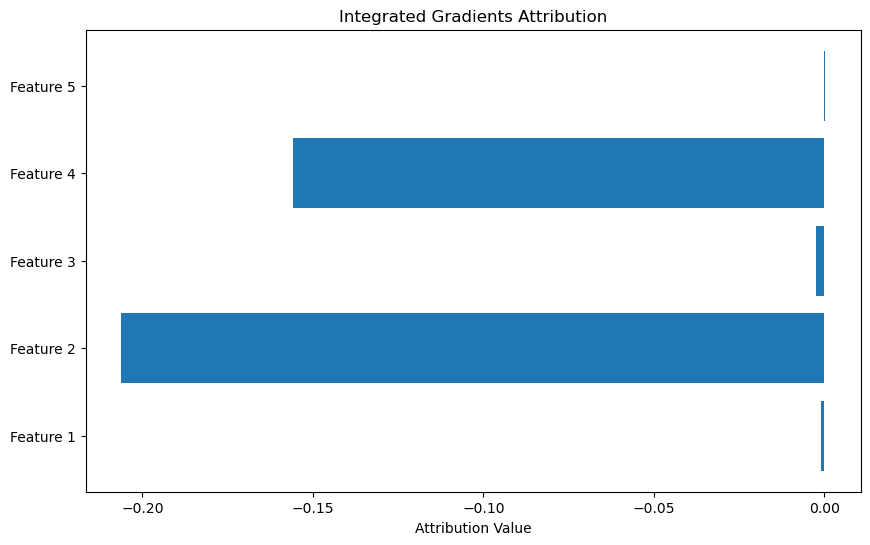

In [ ]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input_data, target=1, n_steps=200)
attributions_ig = attributions_ig.cpu().detach().numpy()
features = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']
plt.figure(figsize=(8, 6))
plt.barh(features, attributions_ig[0])
plt.xlabel('Attribution')
plt.title('Integrated Gradients')
plt.show()